**Goal**<br>
In lectures 8-9 we learned about the implicit bias of logistic regression on separable data towards max-margin classifiers.

The goal of this exercise is to train a ResNet18 model on MNIST and to track throughout the epochs of SGD the distribution of the margins.

Denote by $f_{i,c} \in \mathbb{R}^C$ the logits of the $i$-th training example in the $c$-th class. Denote further by $f_{i,c,c'} \in \mathbb{R}$ the $c'$-th logit. The margin is defined to be $f_{i,c,c} - f_{i,c,c'}$ (for $c \neq c'$).

*Warning: once implemented, running the code will take some time.*

*Before you start, make sure to change the runtime type to include a GPU!*

<br>

**Task 0 (adding three lines of code)**<br>
Repeat the first two steps from the first PyTorch coding exercise.

<br>

**Task 1 (adding 4 lines of code)**<br>
Iterate over the training dataset:
* For each example, calculate its $C-1$ margins
* Append these $C-1$ margins to the list named *all_margins*

Hint: A dataset with $N$ training examples in $C$ classes should have a total of $N \times (C-1)$ margins. 

<br>

**Task 2 (adding 2 lines of code)**<br>
Decrease the learning rate by a factor of 10 after, approximately, $1/2$ and $3/4$ of the total number of epochs.

Hint: lecture on optimization.

<br>

**Task 3: Thinking**<br>
1) At the end of training, are the last-layer train features linearly separable?<br>
2) Can you identify the limiting distribution of the margins?<br>
3) Based on this experiment, can you tell if the last-layer classifier is a max-margin classifier?

Write your answers at the end of your code as a comment.

<br>

**Submission**<br>
*   Download your code by clicking File -> Download .ipynb
*   Submit your downloaded code on Quercus together with a PDF file of your code.

In [30]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt

from torchvision import datasets, transforms

%matplotlib inline

In [31]:
# hyperparameters
device          = "cuda"
lr              = 0.0679
batch_size      = 128
momentum        = 0.9
weight_decay    = 5e-4

epochs          = 32
list_epochs     = [1,2,4,8,16,32]

In [32]:
# deep network
model = models.resnet18(pretrained=False, num_classes=10)

# TASK 0: ADD CODE HERE
model.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model.maxpool = nn.MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)


model = model.to(device)

# dataset loaders
transform = transforms.Compose([transforms.Pad(2),
                                transforms.ToTensor(),
                                transforms.Normalize(0.1307,0.3081)])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', download=True, train=True, transform=transform), 
    batch_size=batch_size, shuffle=True, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', download=True, train=False, transform=transform),
    batch_size=batch_size, shuffle=False, drop_last=False)

# loss function
loss_function = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=lr,
                      momentum=momentum,
                      weight_decay=weight_decay)

# TASK 2: ADD CODE HERE
epochs_lr_decay = [epochs // 2, 3 * (epochs // 4)]

lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer,
                                              milestones=epochs_lr_decay,
                                              gamma=0.1)

Streaming output truncated to the last 5000 lines.
Train		Epoch: 22 	Batch 160/468 (34%) 	Batch Loss: 0.001863 	Batch Accuracy: 99.990234
Train		Epoch: 22 	Batch 161/468 (34%) 	Batch Loss: 0.000931 	Batch Accuracy: 99.990295
Train		Epoch: 22 	Batch 162/468 (35%) 	Batch Loss: 0.001701 	Batch Accuracy: 99.990355
Train		Epoch: 22 	Batch 163/468 (35%) 	Batch Loss: 0.002250 	Batch Accuracy: 99.990414
Train		Epoch: 22 	Batch 164/468 (35%) 	Batch Loss: 0.001271 	Batch Accuracy: 99.990473
Train		Epoch: 22 	Batch 165/468 (35%) 	Batch Loss: 0.002378 	Batch Accuracy: 99.990530
Train		Epoch: 22 	Batch 166/468 (35%) 	Batch Loss: 0.000813 	Batch Accuracy: 99.990587
Train		Epoch: 22 	Batch 167/468 (36%) 	Batch Loss: 0.002703 	Batch Accuracy: 99.990644
Train		Epoch: 22 	Batch 168/468 (36%) 	Batch Loss: 0.001299 	Batch Accuracy: 99.990699
Train		Epoch: 22 	Batch 169/468 (36%) 	Batch Loss: 0.001690 	Batch Accuracy: 99.990754
Train		Epoch: 22 	Batch 170/468 (36%) 	Batch Loss: 0.001788 	Batch Accuracy: 99

Text(0.5, 1.0, 'Distribution of Margins')

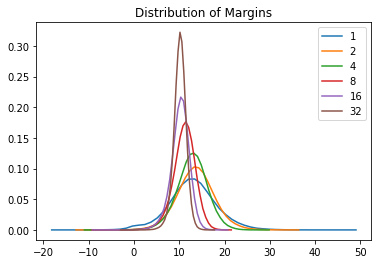

In [33]:
train_accuracy = []
test_accuracy = []

# iterate over epochs
for epoch in range(1, epochs+1):
    # train phase
    model.train()
    accuracy = 0
    N = 0

    all_margins = []

    # iterate over train data
    for batch_idx, (images, labels) in enumerate(train_loader, start=1):
        images, labels = images.to(device), labels.to(device)
        
        # forward pass
        logits = model(images)
        loss = loss_function(logits, labels)

        # TASK 1: ADD CODE HERE
        for i in range(logits.shape[0]):
            
            example = logits[i] # f_ic
            class_logit = example[labels[i]] # f_icc

            for logit in example:
                
                if logit == class_logit:
                    continue
                
                all_margins.append((class_logit - logit).item())


        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(logits,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]

        print('Train\t\tEpoch: {} \t'
              'Batch {}/{} ({:.0f}%) \t'
              'Batch Loss: {:.6f} \t'
              'Batch Accuracy: {:.6f}'.format(
                  epoch,
                  batch_idx,
                  len(train_loader),
                  100. * batch_idx / len(train_loader),
                  loss.item(),
                  100. * accuracy/N))
    train_accuracy.append(100. * accuracy/N)

    # TASK 2: ADD CODE HERE
    lr_scheduler.step()

    if epoch in list_epochs:
        hist, bins_edges = np.histogram(all_margins, bins=50, density=True)
        bin_centers = 0.5*(bins_edges[1:]+bins_edges[:-1])
        plt.plot(bin_centers, hist, label=str(epoch))

    # test phase
    model.eval()
    accuracy = 0
    N = 0

    # iterate over test data
    for batch_idx, (images, labels) in enumerate(test_loader, start=1):
        images, labels = images.to(device), labels.to(device)

        # forward pass
        logits = model(images)
        
        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(logits,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]

    test_accuracy.append(100. * accuracy/N)
    print('Test accuracy:', test_accuracy[-1])

# plot results
plt.legend()
plt.title('Distribution of Margins')

# answer thinking question here

# 1) At the end of training, we can see that the network is classifying with near 
# perfect accuracy and the train loss is close to zero. Due to Neural Collapse, 
# we know that the last-layer train features converge to a Simplex ETF. Thus, 
# these features are linearly separable.

# 2) The limiting distribution of the margins is a point mass with mean 10.

# 3) No, I cant tell if its a max-margin classifier based only on the experiments.